In [ ]:
# --- 1. SETUP AND IMPORTS ---
# Install necessary libraries (only needs to be run once per Colab session)
!pip install rasterio tensorflow pillow

# Import libraries
import os
import numpy as np
import rasterio
from PIL import Image # Used for resizing non-square tiles
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive (You must authorize this)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- 2. CONFIGURATION & CORRECTED DATA LOADING ---
# IMPORTANT: Adjust these paths to match your folder names in Google Drive
ROOT_DIR = '/content/drive/MyDrive'
IMAGE_FOLDER = os.path.join(ROOT_DIR, 'FIRE_TILES_IMAGES')
MASK_FOLDER = os.path.join(ROOT_DIR, 'FIRE_TILES_MASKS')

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 5 # B2, B3, B4, B8, B12 (Blue, Green, Red, NIR, SWIR1)
NUM_TILES = 100  # Max number of tiles exported from GEE

# IMBALANCE FIX: Only load tiles where at least 0.1% of the pixels are marked as burned.
MIN_FIRE_THRESHOLD = 0.001

# --- CORRECTED DATA LOADING FUNCTION (Filtering, Resizing, Normalization) ---

def load_data(img_dir, mask_dir, num_tiles):
    """Loads, resizes, and filters data to exclude tiles with too little fire."""
    X_list = []
    Y_list = []

    print(f"Attempting to load {num_tiles} tiles...")

    for i in range(num_tiles):
        img_path = os.path.join(img_dir, f'S2_tile_{i}.tif')
        mask_path = os.path.join(mask_dir, f'MASK_tile_{i}.tif')

        try:
            # --- Load Image ---
            with rasterio.open(img_path) as src:
                img_array = src.read().transpose(1, 2, 0) # (H, W, C)

                # FIX 1: Resizing Check (for non-square/edge tiles)
                if img_array.shape[0] != IMG_HEIGHT or img_array.shape[1] != IMG_WIDTH:
                    resized_channels = []
                    for c in range(IMG_CHANNELS):
                        resized_channel = np.array(Image.fromarray(img_array[:, :, c].astype(np.uint16)).resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST))
                        resized_channels.append(resized_channel)
                    img_array = np.stack(resized_channels, axis=-1)

                img_array = np.clip(img_array / 10000.0, 0.0, 1.0)

            # --- Load Mask ---
            with rasterio.open(mask_path) as src:
                mask_array = src.read(1) # (H, W)

                # Resizing Check
                if mask_array.shape[0] != IMG_HEIGHT or mask_array.shape[1] != IMG_WIDTH:
                    mask_array = np.array(Image.fromarray(mask_array.astype(np.uint8)).resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST))

                mask_array = np.expand_dims(mask_array, axis=-1)
                mask_array = np.clip(mask_array, 0.0, 1.0).astype(np.float32)

            # FIX 2: IMBALANCE FILTER
            fire_pixel_count = np.sum(mask_array)
            fire_ratio = fire_pixel_count / mask_array.size

            if fire_ratio < MIN_FIRE_THRESHOLD:
                # print(f"Skipping tile {i} (Ratio: {fire_ratio:.5f}).") # Uncomment to see which tiles are skipped
                continue

            X_list.append(img_array)
            Y_list.append(mask_array)

        except rasterio.RasterioIOError:
            continue

    X_data = np.array(X_list)
    Y_data = np.array(Y_list)

    print(f"\nSuccessfully loaded {len(X_data)} tile pairs after filtering.")
    return X_data, Y_data

# Execute data loading and splitting
X_data, Y_data = load_data(IMAGE_FOLDER, MASK_FOLDER, NUM_TILES)

if len(X_data) < 2:
    print("\nERROR: Not enough tiles with fire pixels to train. Check GEE export or adjust MIN_FIRE_THRESHOLD.")
    # Use dummy arrays to prevent immediate error if running the whole script
    X_train, X_val, X_test = np.array([]), np.array([]), np.array([])
    Y_train, Y_val, Y_test = np.array([]), np.array([]), np.array([])
else:
    X_train, X_temp, Y_train, Y_temp = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
    print(f"\nTrain samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")

Attempting to load 100 tiles...


/tmp/ipython-input-3358733659.py:37: RuntimeWarning: invalid value encountered in cast
  resized_channel = np.array(Image.fromarray(img_array[:, :, c].astype(np.uint16)).resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST))



Successfully loaded 34 tile pairs after filtering.

Train samples: 23
Validation samples: 5
Test samples: 6


In [ ]:
# --- CORRECTED DATA LOADING FUNCTION (Filtering, Resizing, Normalization, NO-DATA FIX) ---

def load_data(img_dir, mask_dir, num_tiles):
    """Loads, resizes, filters, and CLEANS mask data (No-Data fix)."""
    X_list = []
    Y_list = []

    print(f"Attempting to load {num_tiles} tiles...")

    for i in range(num_tiles):
        img_path = os.path.join(img_dir, f'S2_tile_{i}.tif')
        mask_path = os.path.join(mask_dir, f'MASK_tile_{i}.tif')

        try:
            # --- Load Image (No-Data not critical here, but good practice) ---
            with rasterio.open(img_path) as src:
                img_array = src.read().transpose(1, 2, 0) # (H, W, C)

                # FIX 1: Resizing Check (for non-square/edge tiles)
                if img_array.shape[0] != IMG_HEIGHT or img_array.shape[1] != IMG_WIDTH:
                    resized_channels = []
                    for c in range(IMG_CHANNELS):
                        resized_channel = np.array(Image.fromarray(img_array[:, :, c].astype(np.uint16)).resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST))
                        resized_channels.append(resized_channel)
                    img_array = np.stack(resized_channels, axis=-1)

                img_array = np.clip(img_array / 10000.0, 0.0, 1.0)

            # --- Load Mask ---
            with rasterio.open(mask_path) as src:
                mask_array = src.read(1) # (H, W)

                # --- FIX 3: NO-DATA MASKING ---
                nodata_value = src.nodata
                if nodata_value is not None and nodata_value != 0:
                    # Replace all nodata pixels (the grey background) with 0 (unburned).
                    mask_array[mask_array == nodata_value] = 0

                # Resizing Check
                if mask_array.shape[0] != IMG_HEIGHT or mask_array.shape[1] != IMG_WIDTH:
                    mask_array = np.array(Image.fromarray(mask_array.astype(np.uint8)).resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST))

                # Finalize mask
                mask_array = np.expand_dims(mask_array, axis=-1)
                # Ensure values are strictly 0 or 1 floats
                mask_array = np.clip(mask_array, 0.0, 1.0).astype(np.float32)

            # FIX 2: IMBALANCE FILTER
            fire_pixel_count = np.sum(mask_array)
            fire_ratio = fire_pixel_count / mask_array.size

            if fire_ratio < MIN_FIRE_THRESHOLD:
                # print(f"Skipping tile {i} (Ratio: {fire_ratio:.5f}).")
                continue

            X_list.append(img_array)
            Y_list.append(mask_array)

        except rasterio.RasterioIOError:
            continue

    X_data = np.array(X_list)
    Y_data = np.array(Y_list)

    print(f"\nSuccessfully loaded {len(X_data)} tile pairs after filtering.")
    return X_data, Y_data

# --- The rest of the execution block below the function remains unchanged ---

# Execute data loading and splitting
# X_data, Y_data = load_data(IMAGE_FOLDER, MASK_FOLDER, NUM_TILES)
# ... (rest of the splitting logic)

In [ ]:
# --- 3. MODEL DEFINITION & COMPILE (with Weighted Loss Fixes) ---

# --- U-NET ARCHITECTURE (Standard) ---
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', kernel_initializer='he_normal')(input_tensor)
    if batchnorm: x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', kernel_initializer='he_normal')(x)
    if batchnorm: x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def get_unet_model(input_img, n_filters=16, batchnorm=True):
    # (U-Net construction)
    c1 = conv2d_block(input_img, n_filters * 1, batchnorm=batchnorm); p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv2d_block(p1, n_filters * 2, batchnorm=batchnorm); p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv2d_block(p2, n_filters * 4, batchnorm=batchnorm); p3 = MaxPooling2D((2, 2))(c3)
    c4 = conv2d_block(p3, n_filters * 8, batchnorm=batchnorm); p4 = MaxPooling2D((2, 2))(c4)
    c5 = conv2d_block(p4, n_filters * 16, batchnorm=batchnorm)
    u6 = UpSampling2D((2, 2))(c5); u6 = concatenate([u6, c4]); c6 = conv2d_block(u6, n_filters * 8, batchnorm=batchnorm)
    u7 = UpSampling2D((2, 2))(c6); u7 = concatenate([u7, c3]); c7 = conv2d_block(u7, n_filters * 4, batchnorm=batchnorm)
    u8 = UpSampling2D((2, 2))(c7); u8 = concatenate([u8, c2]); c8 = conv2d_block(u8, n_filters * 2, batchnorm=batchnorm)
    u9 = UpSampling2D((2, 2))(c8); u9 = concatenate([u9, c1]); c9 = conv2d_block(u9, n_filters * 1, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# --- CUSTOM WEIGHTED LOSS (Imbalance Fix) ---
WEIGHT_FACTOR = 10.0 # Fire pixels are 10x more important

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1.0 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# FIX: Added tf.expand_dims to resolve the InvalidArgumentError (shape mismatch)
def weighted_bce_loss(y_true, y_pred):
    # Calculate weights (shape: [B, H, W, 1])
    weights = y_true * (WEIGHT_FACTOR - 1.0) + 1.0

    # Calculate raw BCE per pixel (shape: [B, H, W])
    bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)

    # FIX: Expand dimensions to match the weights tensor [B, H, W] -> [B, H, W, 1]
    bce = tf.expand_dims(bce, axis=-1)

    # Perform weighted multiplication (Now compatible: [B, H, W, 1] * [B, H, W, 1])
    weighted_bce = bce * weights

    return tf.reduce_mean(weighted_bce)

# Combined Loss: Mix Weighted BCE (40%) and Dice Loss (60%)
def combined_weighted_loss(y_true, y_pred):
    w_bce = weighted_bce_loss(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return (0.4 * w_bce) + (0.6 * dice)


# Create the model instance
input_img = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='input_img')
model = get_unet_model(input_img, n_filters=16)

# Compile the model
model.compile(optimizer='adam',
              loss=combined_weighted_loss,
              # FIX: Use built-in Keras class for stable metric calculation
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2, name='mean_iou')])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │        736 │ input_img[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │      2,320 │ activation_54[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ activation_55[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_56[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ activation_57[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_61[0][0] 

 Total params: 1,968,801 (7.51 MB)

 Trainable params: 1,965,857 (7.50 MB)

 Non-trainable params: 2,944 (11.50 KB)


Starting training...
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5751 - loss: 1.1253 - mean_iou: 0.4298 
Epoch 1: val_mean_iou improved from -inf to 0.46378, saving model to best_fire_model.weights.h5
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 24s/step - accuracy: 0.5738 - loss: 1.1305 - mean_iou: 0.4293 - val_accuracy: 0.7090 - val_loss: 0.9664 - val_mean_iou: 0.4638
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5273 - loss: 1.0886 - mean_iou: 0.4231
Epoch 2: val_mean_iou did not improve from 0.46378
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.5289 - loss: 1.0819 - mean_iou: 0.4248 - val_accuracy: 0.9267 - val_loss: 1.9002 - val_mean_iou: 0.4638
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4902 - loss: 1.0203 - mean_iou: 0.4283 
Epoch 3: val_mean_iou did not improve from 0.46378
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.4916 - loss: 1.0165 - mean_iou: 0.4283 - val_accuracy: 0.9194 - val_loss: 1.6909 - val_mean_iou: 0.4638
Epo

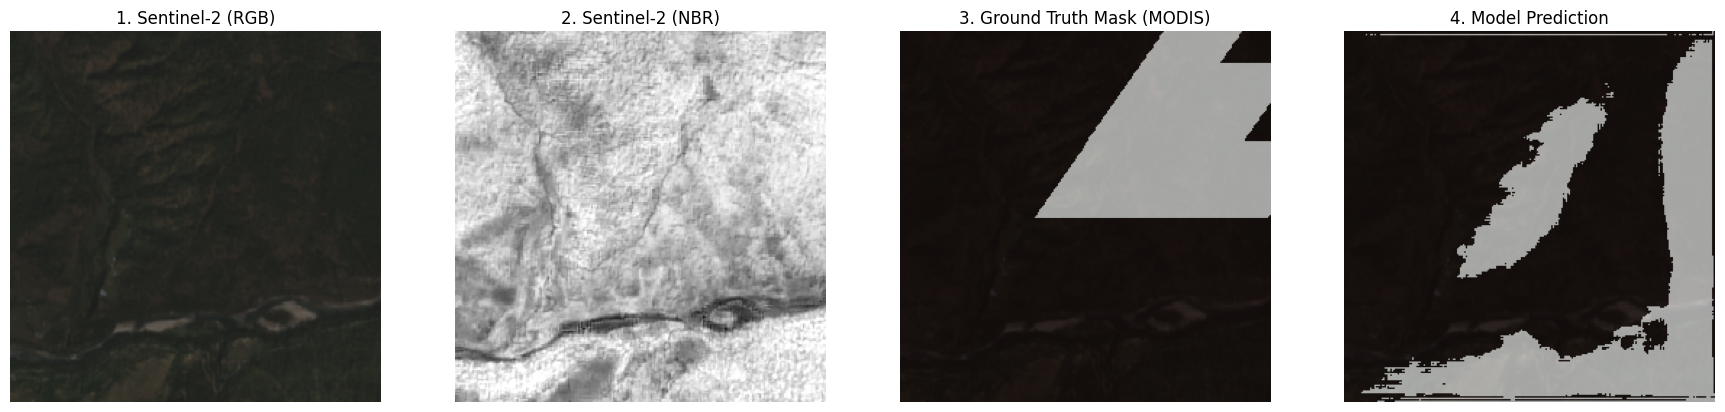

In [ ]:
# --- 4. TRAINING AND EVALUATION ---

BATCH_SIZE = 16
EPOCHS = 50

# FIX: Overfitting Prevention (Early Stopping)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# FIX: File Name Correction (.weights.h5)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_fire_model.weights.h5',
    save_weights_only=True,
    monitor='val_mean_iou',
    mode='max',
    save_best_only=True,
    verbose=1
)

if len(X_train) > 0:
    print("\nStarting training...")

    # Train the model
    history = model.fit(
        X_train,
        Y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, Y_val),
        callbacks=[model_checkpoint_callback, early_stopping_callback]
    )
    print("Training finished. Best model weights saved.")
else:
    print("\nSkipping training: Not enough filtered data (X_train is empty).")
    history = None


# --- EVALUATION ---
if len(X_test) > 0:
    try:
        # FIX: Load the corrected file name
        model.load_weights('best_fire_model.weights.h5')
    except:
        print("WARNING: Could not load best weights. Using final epoch weights.")

    print("\nEvaluating on Test Set...")
    loss, acc, iou = model.evaluate(X_test, Y_test, verbose=1)
    print(f"\n--- Final Model Performance ---")
    print(f"Test Loss (Combined Weighted): {loss:.4f}")
    print(f"Test Pixel Accuracy: {acc:.4f}")
    print(f"Test IoU: {iou:.4f}")
    print("-----------------------------------")


# --- ENHANCED VISUALIZATION (with NBR) ---

def show_prediction(X_data, Y_data, model, index):
    """Shows RGB, NBR, Ground Truth, and Model Prediction for a tile."""
    img = X_data[index]
    gt_mask = Y_data[index].squeeze()
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0].squeeze()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # 1. Natural Color (B4, B3, B2)
    natural_color = img[:, :, [2, 1, 0]]

    # 2. Normalized Burn Ratio (NBR) for fire visualization
    # Bands: [..., NIR(B8), SWIR1(B12)] -> indices 3 and 4
    NIR = img[:, :, 3]
    SWIR = img[:, :, 4]

    numerator = NIR - SWIR
    denominator = NIR + SWIR + 1e-6
    NBR = numerator / denominator

    # Scale NBR for display (contrast enhancement)
    NBR_min, NBR_max = -0.4, 0.4
    NBR_display = np.clip((NBR - NBR_min) / (NBR_max - NBR_min), 0, 1)

    fig, axes = plt.subplots(1, 4, figsize=(22, 6))

    axes[0].imshow(natural_color); axes[0].set_title('1. Sentinel-2 (RGB)')
    axes[1].imshow(NBR_display, cmap='gray'); axes[1].set_title('2. Sentinel-2 (NBR)')
    axes[2].imshow(natural_color); axes[2].imshow(gt_mask, cmap='hot', alpha=0.6); axes[2].set_title('3. Ground Truth Mask (MODIS)')
    axes[3].imshow(natural_color); axes[3].imshow(pred_mask, cmap='hot', alpha=0.6); axes[3].set_title('4. Model Prediction')

    for ax in axes: ax.axis('off')
    plt.show()

# Show prediction for the 10th tile in the test set
if len(X_test) > 10:
    show_prediction(X_test, Y_test, model, 10)
elif len(X_test) > 0:
    show_prediction(X_test, Y_test, model, 0)
else:
    print("Cannot visualize: Test set is empty.")

# **New model training**

In [ ]:
torch.backends.cudnn.benchmark = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/FIRE_TILES_IMAGES"
MASK_DIR  = "/content/drive/MyDrive/FIRE_TILES_MASKS"

In [ ]:
IMAGE_SIZE = 256    # tile size for model
BATCH_SIZE = 4
NUM_WORKERS = 2     # adjust for Colab: 2 is safe
LR = 1e-4
EPOCHS = 20
MODEL_CHECKPOINT = "/content/drive/MyDrive/fire_raunet_best.pth"


In [ ]:
# Quick sanity print
print("Image folder exists:", os.path.exists(IMAGE_DIR))
print("Mask folder exists:", os.path.exists(MASK_DIR))


Image folder exists: True
Mask folder exists: True


In [ ]:
# ---- 4. Robust Dataset for 5-band GeoTIFFs ----
class FireDataset(Dataset):
    """
    Reads 5-band GeoTIFF images (bands order unknown but script assumes exported in consistent order)
    Expects images as .tif and masks as .tif (single-band).
    Auto resizes to IMAGE_SIZE.
    Normalizes image by a scale (10000 typical for Sentinel reflectance).
    Outputs:
        img: Tensor [C, H, W] floats in [0,1]
        mask: Tensor [1, H, W] floats 0 or 1
    """
    def __init__(self, img_dir, mask_dir, size=IMAGE_SIZE, img_ext=".tif", mask_ext=".tif", scale=10000.0, min_valid_area=0.0):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size
        self.scale = scale
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(img_ext)])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(mask_ext)])
        # Basic sanity: only keep pairs with same index/name prefix if possible
        # For simplicity we assume matching order; you can implement name matching if required.
        n = min(len(self.img_files), len(self.mask_files))
        self.img_files = self.img_files[:n]
        self.mask_files = self.mask_files[:n]
        self.min_valid_area = min_valid_area  # fraction threshold for skipping tiles (0=keep all)

    def __len__(self):
        return len(self.img_files)

    def read_tif(self, path):
        # returns numpy array shape (bands, H, W)
        with rasterio.open(path) as src:
            arr = src.read()  # (C,H,W)
            # convert masked arrays / NaNs to zeros
            if hasattr(arr, "filled"):
                arr = arr.filled(0)
            arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
        return arr

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        msk_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # Load with rasterio
        img = self.read_tif(img_path)   # shape (C,H,W)
        mask = self.read_tif(msk_path)  # mask may be single-band -> shape (1,H,W) or (H,W)

        # If mask has >1 band, take first
        if mask.ndim == 3:
            if mask.shape[0] > 1:
                mask = mask[0]
            else:
                mask = mask.squeeze(0)
        # Ensure shape conventions
        if img.ndim == 2:
            # single band -> make it (1,H,W)
            img = img[np.newaxis, :, :]

        # Basic consistency: if image band count is last dim (H,W,C), handle (rare)
        if img.shape[0] > img.shape[-1] and img.shape[-1] in (3,4,5,6):
            # some readers might return (H,W,C). Try to detect and transpose.
            if img.shape[-1] != img.shape[0]:
                img = np.transpose(img, (2,0,1))

        # Convert to floats and normalize
        img = img.astype(np.float32) / float(self.scale)
        img = np.clip(img, 0.0, 1.0)

        # Convert mask: ensure binary 0/1 float
        mask = mask.astype(np.float32)
        # If mask values are 255, convert to 1
        mask = np.where(mask > 0.5, 1.0, 0.0)

        # Resize to (size,size) using torch.interpolate later -> convert to tensor
        img_tensor = torch.from_numpy(img)           # (C,H,W)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)  # (1,H,W)

        # Resize using interpolate requires batch dim
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(self.size, self.size), mode="bilinear", align_corners=False).squeeze(0)
        mask_tensor = F.interpolate(mask_tensor.unsqueeze(0), size=(self.size, self.size), mode="nearest").squeeze(0)

        # Clean NaNs / infinities
        img_tensor = torch.nan_to_num(img_tensor, nan=0.0, posinf=1.0, neginf=0.0)
        img_tensor = torch.clamp(img_tensor, 0.0, 1.0)

        mask_tensor = torch.nan_to_num(mask_tensor, nan=0.0, posinf=1.0, neginf=0.0)
        mask_tensor = torch.clamp(mask_tensor, 0.0, 1.0)

        # Optionally skip tiles without any fire (handled externally if desired).
        if self.min_valid_area > 0:
            fire_ratio = mask_tensor.sum().item() / (self.size * self.size)
            if fire_ratio < self.min_valid_area:
                # If too small, return a special signal — but DataLoader does not accept None, so we still return it.
                pass

        return img_tensor.float(), mask_tensor.float()


In [ ]:
# ---- 5. Build dataset and loaders ----

from torch.utils.data import DataLoader, Dataset, random_split   # <-- ADD THIS

dataset = FireDataset(
    IMAGE_DIR,
    MASK_DIR,
    size=IMAGE_SIZE,
    scale=10000.0,
    min_valid_area=0.0
)
print("Total pairs found:", len(dataset))

# Quick check of one sample
if len(dataset) > 0:
    x0, y0 = dataset[0]
    print("Sample shapes:", x0.shape, y0.shape)

# Split
train_frac = 0.8
n = len(dataset)
n_train = int(n * train_frac)
n_val = n - n_train

if n < 2:
    raise RuntimeError("Not enough data in dataset. Please check your exported tiles & masks.")

train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)


Total pairs found: 100
Sample shapes: torch.Size([5, 256, 256]) torch.Size([1, 256, 256])


In [ ]:
# ---- 6. RA-UNet model (fixed attention, returns logits) ----
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class AttentionGate(nn.Module):
    def __init__(self, g_ch, x_ch, inter_ch):
        super().__init__()
        self.Wg = nn.Sequential(nn.Conv2d(g_ch, inter_ch, 1, bias=False), nn.BatchNorm2d(inter_ch))
        self.Wx = nn.Sequential(nn.Conv2d(x_ch, inter_ch, 1, bias=False), nn.BatchNorm2d(inter_ch))
        self.psi = nn.Sequential(nn.Conv2d(inter_ch, 1, 1, bias=False), nn.BatchNorm2d(1), nn.Sigmoid())
    def forward(self, g, x):
        # Upsample gating signal g to match x spatial size if needed
        if g.shape[2:] != x.shape[2:]:
            g = F.interpolate(g, size=x.shape[2:], mode='bilinear', align_corners=False)
        g1 = self.Wg(g)
        x1 = self.Wx(x)
        psi = torch.relu(g1 + x1)
        psi = self.psi(psi)  # (B,1,H,W)
        return x * psi

class RAUNet(nn.Module):
    def __init__(self, in_channels=5, base_filters=32):
        super().__init__()
        f = base_filters
        self.enc1 = ConvBlock(in_channels, f)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(f, f*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(f*2, f*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(f*4, f*8)
        self.pool4 = nn.MaxPool2d(2)
        self.center = ConvBlock(f*8, f*16)

        self.up4 = nn.ConvTranspose2d(f*16, f*8, 2, 2)
        self.att4 = AttentionGate(g_ch=f*8, x_ch=f*8, inter_ch=f*4)
        self.dec4 = ConvBlock(f*16, f*8)

        self.up3 = nn.ConvTranspose2d(f*8, f*4, 2, 2)
        self.att3 = AttentionGate(g_ch=f*4, x_ch=f*4, inter_ch=f*2)
        self.dec3 = ConvBlock(f*8, f*4)

        self.up2 = nn.ConvTranspose2d(f*4, f*2, 2, 2)
        self.att2 = AttentionGate(g_ch=f*2, x_ch=f*2, inter_ch=f)
        self.dec2 = ConvBlock(f*4, f*2)

        self.up1 = nn.ConvTranspose2d(f*2, f, 2, 2)
        self.att1 = AttentionGate(g_ch=f, x_ch=f, inter_ch=max(f//2,1))
        self.dec1 = ConvBlock(f*2, f)

        self.final = nn.Conv2d(f, 1, 1)  # logits output (no sigmoid)

    def forward(self, x):
        e1 = self.enc1(x)      # [B, f, H, W]
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)     # [B,2f,H/2,W/2]
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)     # [B,4f,H/4,W/4]
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)     # [B,8f,H/8,W/8]
        p4 = self.pool4(e4)

        c = self.center(p4)    # [B,16f,H/16,W/16]

        u4 = self.up4(c)       # -> [B,8f,H/8,W/8]
        ae4 = self.att4(u4, e4)
        d4 = self.dec4(torch.cat([u4, ae4], dim=1))

        u3 = self.up3(d4)      # -> [B,4f,H/4,W/4]
        ae3 = self.att3(u3, e3)
        d3 = self.dec3(torch.cat([u3, ae3], dim=1))

        u2 = self.up2(d3)      # -> [B,2f,H/2,W/2]
        ae2 = self.att2(u2, e2)
        d2 = self.dec2(torch.cat([u2, ae2], dim=1))

        u1 = self.up1(d2)      # -> [B,f,H,W]
        ae1 = self.att1(u1, e1)
        d1 = self.dec1(torch.cat([u1, ae1], dim=1))

        logits = self.final(d1)
        return logits  # logits (use BCEWithLogitsLoss)


In [ ]:
# ---- 7. Loss: BCEWithLogits + custom Focal-Tversky (applies sigmoid inside) ----
class FocalTversky(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth
    def forward(self, logits, targets):
        # logits: raw model outputs
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)
        TP = (probs * targets).sum()
        FP = (probs * (1 - targets)).sum()
        FN = ((1 - probs) * targets).sum()
        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        loss = (1 - tversky) ** self.gamma
        return loss

# Combined loss wrapper
bce_loss = nn.BCEWithLogitsLoss()
focal_tversky = FocalTversky(alpha=0.7, beta=0.3, gamma=0.75)

def combined_loss(logits, targets, w_bce=0.5, w_ft=0.5):
    b = bce_loss(logits, targets)
    ft = focal_tversky(logits, targets)
    return w_bce * b + w_ft * ft

# Metric: IoU (for evaluation), uses probs from logits
def iou_metric(logits, targets, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    inter = (preds * targets).sum()
    union = ((preds + targets) >= 1).float().sum()
    if union == 0:
        return torch.tensor(1.0)  # perfect empty prediction
    return inter / (union + 1e-6)


In [ ]:
# ---- 8. Instantiate model, optimizer, scaler ----
model = RAUNet(in_channels=5, base_filters=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler() if device == "cuda" else None

# Print model size
print("Model created. Parameters:", sum(p.numel() for p in model.parameters()))
# Optional: print(summary) if torchsummary installed

Model created. Parameters: 7851865


/tmp/ipython-input-2596518642.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device == "cuda" else None


In [ ]:
# ---- 9. Stable training loop with checks, AMP, gradient clipping ----
best_val_iou = 0.0
os.makedirs(os.path.dirname(MODEL_CHECKPOINT), exist_ok=True)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    count = 0

    for batch_idx, (imgs, masks) in enumerate(train_loader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        # Mixed precision
        if device == "cuda":
            with torch.cuda.amp.autocast():
                logits = model(imgs)  # raw outputs
                loss = combined_loss(logits, masks)
            # detect NaN loss
            if torch.isnan(loss):
                print("NaN loss detected at train batch", batch_idx)
                print("img min/max:", imgs.min().item(), imgs.max().item())
                print("mask min/max:", masks.min().item(), masks.max().item())
                raise RuntimeError("NaN loss during training.")
            scaler.scale(loss).backward()
            # gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(imgs)
            loss = combined_loss(logits, masks)
            if torch.isnan(loss):
                raise RuntimeError("NaN loss (CPU).")
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        epoch_loss += loss.item()
        count += 1

    avg_loss = epoch_loss / max(1, count)

    # Validation pass (compute IoU)
    model.eval()
    val_iou = 0.0
    vcount = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            logits = model(imgs)
            val_iou += iou_metric(logits, masks).item()
            vcount += 1
    val_iou = val_iou / max(1, vcount)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f} - Val IoU: {val_iou:.4f}")

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_CHECKPOINT)
        print("Saved best model:", MODEL_CHECKPOINT)


/tmp/ipython-input-2988849124.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/20 - Loss: 0.8111 - Val IoU: 0.0240
Saved best model: /content/drive/MyDrive/fire_raunet_best.pth
Epoch 2/20 - Loss: 0.7524 - Val IoU: 0.0158
Epoch 3/20 - Loss: 0.7275 - Val IoU: 0.0097
Epoch 4/20 - Loss: 0.7168 - Val IoU: 0.0039
Epoch 5/20 - Loss: 0.7080 - Val IoU: 0.0006
Epoch 6/20 - Loss: 0.7067 - Val IoU: 0.0002
Epoch 7/20 - Loss: 0.6960 - Val IoU: 0.4000
Saved best model: /content/drive/MyDrive/fire_raunet_best.pth
Epoch 8/20 - Loss: 0.6904 - Val IoU: 0.4000
Epoch 9/20 - Loss: 0.6862 - Val IoU: 0.4000
Epoch 10/20 - Loss: 0.6835 - Val IoU: 0.4000
Epoch 11/20 - Loss: 0.6782 - Val IoU: 0.4000
Epoch 12/20 - Loss: 0.6744 - Val IoU: 0.4000
Epoch 13/20 - Loss: 0.6721 - Val IoU: 0.4000
Epoch 14/20 - Loss: 0.6695 - Val IoU: 0.4000
Epoch 15/20 - Loss: 0.6666 - Val IoU: 0.4000
Epoch 16/20 - Loss: 0.6655 - Val IoU: 0.4000
Epoch 17/20 - Loss: 0.6625 - Val IoU: 0.4000
Epoch 18/20 - Loss: 0.6612 - Val IoU: 0.4000
Epoch 19/20 - Loss: 0.6576 - Val IoU: 0.4000
Epoch 20/20 - Loss: 0.6543 - V

In [ ]:
# ---- 10. Load best model for inference ----
model.load_state_dict(torch.load(MODEL_CHECKPOINT, map_location=device))
model.eval()
print("Best model loaded. Best val IoU:", best_val_iou)

Best model loaded. Best val IoU: 0.4000096223237051


In [ ]:
# ---- 11. Visualization helpers (RGB, NBR, overlay) ----
def get_rgb_from_5band_array(img_arr):
    # img_arr expected shape (H,W,5) or (5,H,W)
    if img_arr.ndim == 3 and img_arr.shape[0] == 5:
        img_arr = np.transpose(img_arr, (1,2,0))
    # True color (R=band4, G=band3, B=band2) indices in exported order: [B2,B3,B4,B8,B12]
    # So R=idx2, G=idx1, B=idx0
    r = img_arr[:,:,2]
    g = img_arr[:,:,1]
    b = img_arr[:,:,0]
    rgb = np.stack([r,g,b], axis=-1)
    # Contrast stretch percentiles
    p = np.percentile(rgb, 99)
    rgb = rgb / (p + 1e-6)
    rgb = np.clip(rgb, 0, 1)
    return rgb

def compute_nbr(img_arr):
    # expects (H,W,5)
    if img_arr.ndim == 3 and img_arr.shape[0] == 5:
        img_arr = np.transpose(img_arr, (1,2,0))
    nir = img_arr[:,:,3]   # band 8
    swir = img_arr[:,:,4]  # band 12
    nbr = (nir - swir) / (nir + swir + 1e-6)
    return nbr

def visualize_prediction_on_tile(tile_path, show_overlay=True, threshold=0.5):
    # load tile with rasterio as (bands, H, W)
    with rasterio.open(tile_path) as src:
        arr = src.read().astype(np.float32)  # (C,H,W)
    arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
    # convert to H,W,C
    arr_hw = reshape_as_image(arr)  # (H,W,C)
    # Normalize to 0..1 by scale assumption (use sentinel scale 10000)
    arr_hw_clip = np.clip(arr_hw / 10000.0, 0.0, 1.0)

    # Prepare input tensor (C,H,W) and resize to model size
    inp = torch.from_numpy(np.transpose(arr_hw_clip, (2,0,1))).unsqueeze(0).float().to(device)
    inp = F.interpolate(inp, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)

    with torch.no_grad():
        logits = model(inp)
        probs = torch.sigmoid(logits)[0,0].cpu().numpy()  # (H,W) model-sized

    # Resize probs up to original tile display size for overlay
    probs_up = np.array(Image.fromarray((probs*255).astype(np.uint8)).resize((arr_hw.shape[1], arr_hw.shape[0]), resample=Image.BILINEAR)) / 255.0

    rgb = get_rgb_from_5band_array(arr_hw)
    nbr = compute_nbr(arr_hw)

    # Plot
    fig, ax = plt.subplots(1,3, figsize=(18,6))
    ax[0].imshow(rgb); ax[0].set_title("True Color (RGB)"); ax[0].axis('off')
    ax[1].imshow(nbr, cmap='inferno'); ax[1].set_title("NBR"); ax[1].axis('off')
    ax[2].imshow(rgb);
    if show_overlay:
        ax[2].imshow(probs_up, cmap='hot', alpha=0.5)
    ax[2].set_title("Prediction overlay (hot = fire prob)"); ax[2].axis('off')
    plt.show()


Upload one 5-band GeoTIFF tile (or choose from DRIVE and give path).


Saving S2_tile_1.tif to S2_tile_1.tif
Uploaded: /content/S2_tile_1.tif


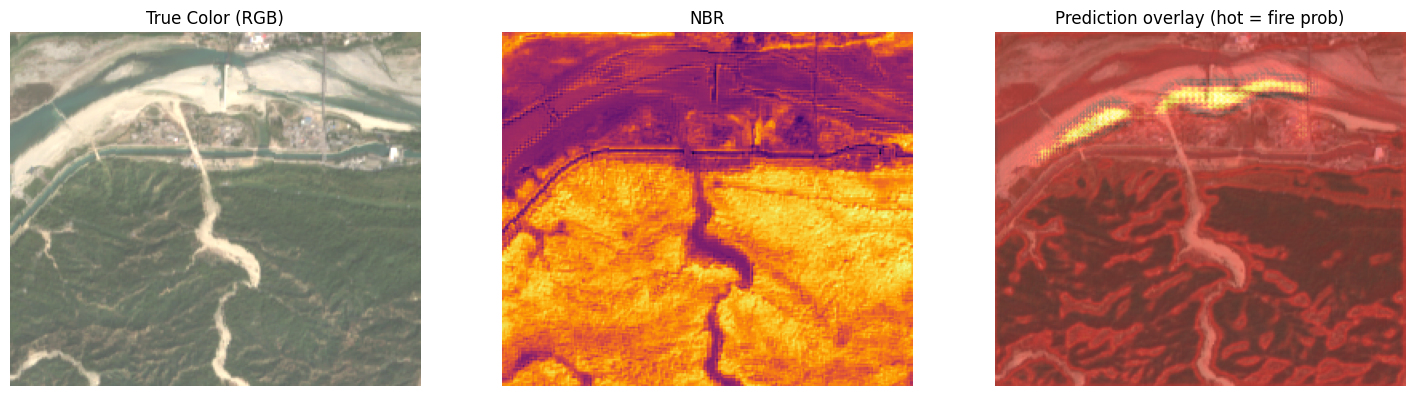

In [ ]:
from google.colab import files
from PIL import Image

print("Upload one 5-band GeoTIFF tile (or choose from DRIVE and give path).")
uploaded = files.upload()  # this opens dialog; returns dict {filename: bytes}
if len(uploaded) > 0:
    test_filename = list(uploaded.keys())[0]
    test_path = f"/content/{test_filename}"
    # file is saved in /content by files.upload
    print("Uploaded:", test_path)
    visualize_prediction_on_tile(test_path, show_overlay=True)
else:
    print("No file uploaded via interface. You can call visualize_prediction_on_tile('/content/drive/.../S2_tile_0.tif') manually.")


Upload one 5-band GeoTIFF tile (or choose from DRIVE and give path).


Saving S2_tile_9.tif to S2_tile_9.tif
Uploaded: /content/S2_tile_9.tif


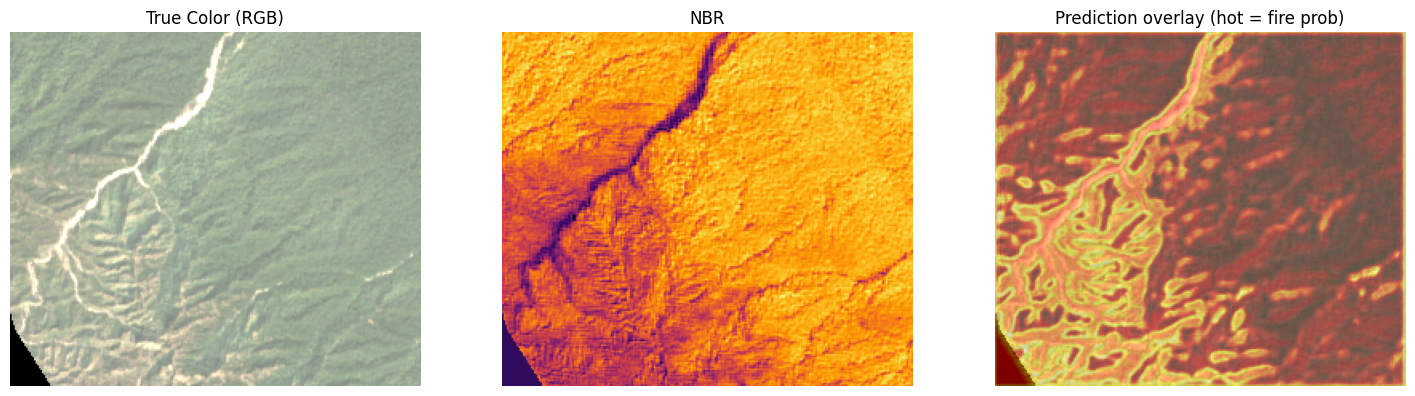

In [ ]:
from google.colab import files
from PIL import Image

print("Upload one 5-band GeoTIFF tile (or choose from DRIVE and give path).")
uploaded = files.upload()  # this opens dialog; returns dict {filename: bytes}
if len(uploaded) > 0:
    test_filename = list(uploaded.keys())[0]
    test_path = f"/content/{test_filename}"
    # file is saved in /content by files.upload
    print("Uploaded:", test_path)
    visualize_prediction_on_tile(test_path, show_overlay=True)
else:
    print("No file uploaded via interface. You can call visualize_prediction_on_tile('/content/drive/.../S2_tile_0.tif') manually.")


Upload one 5-band GeoTIFF tile (or choose from DRIVE and give path).


Saving S2_tile_25.tif to S2_tile_25.tif
Uploaded: /content/S2_tile_25.tif


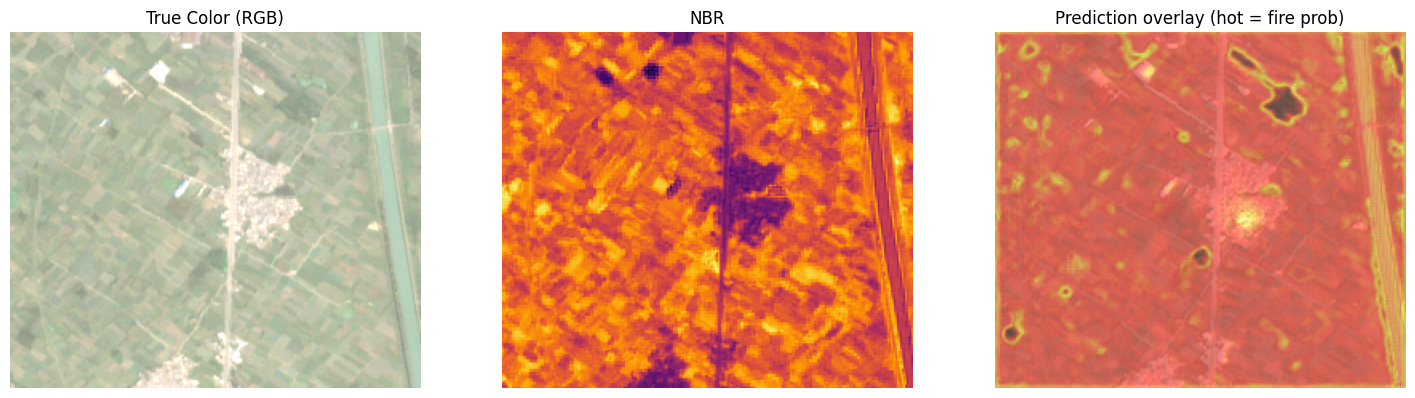

In [ ]:
from google.colab import files
from PIL import Image

print("Upload one 5-band GeoTIFF tile (or choose from DRIVE and give path).")
uploaded = files.upload()  # this opens dialog; returns dict {filename: bytes}
if len(uploaded) > 0:
    test_filename = list(uploaded.keys())[0]
    test_path = f"/content/{test_filename}"
    # file is saved in /content by files.upload
    print("Uploaded:", test_path)
    visualize_prediction_on_tile(test_path, show_overlay=True)
else:
    print("No file uploaded via interface. You can call visualize_prediction_on_tile('/content/drive/.../S2_tile_0.tif') manually.")

Upload one 5-band GeoTIFF tile (or choose from DRIVE and give path).


Saving S2_tile_96.tif to S2_tile_96.tif
Uploaded: /content/S2_tile_96.tif


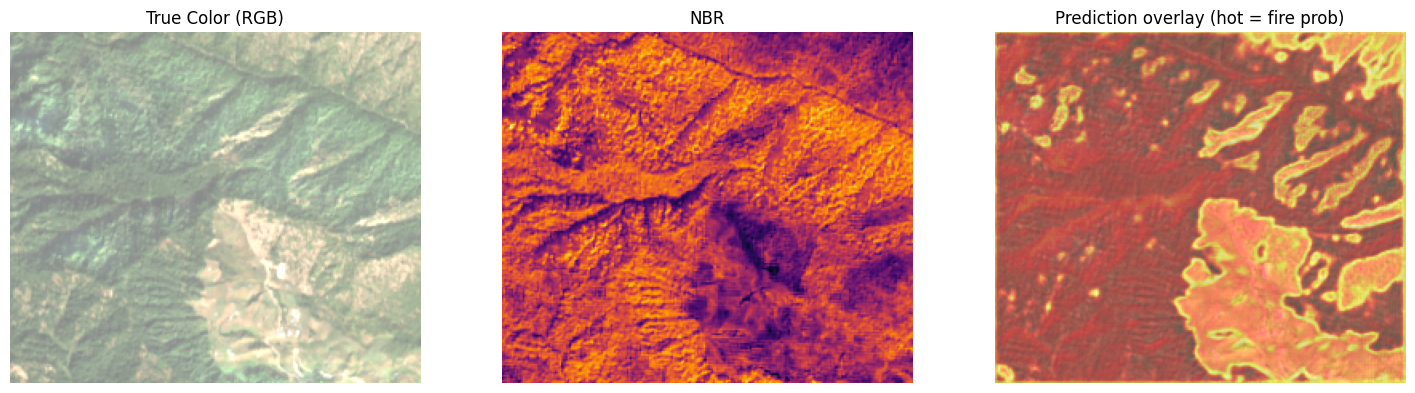

In [ ]:
from google.colab import files
from PIL import Image

print("Upload one 5-band GeoTIFF tile (or choose from DRIVE and give path).")
uploaded = files.upload()  # this opens dialog; returns dict {filename: bytes}
if len(uploaded) > 0:
    test_filename = list(uploaded.keys())[0]
    test_path = f"/content/{test_filename}"
    # file is saved in /content by files.upload
    print("Uploaded:", test_path)
    visualize_prediction_on_tile(test_path, show_overlay=True)
else:
    print("No file uploaded via interface. You can call visualize_prediction_on_tile('/content/drive/.../S2_tile_0.tif') manually.")